In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.externals import joblib
from sklearn import tree
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.grid_search import GridSearchCV

/home/expertsvision/Desktop/GA_implemented_with_flask/server/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/expertsvision/Desktop/GA_implemented_with_flask/server/venv/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def get_time(x, c1, c2):     #find the difference between two date columns of dataframe x
    diff =  x[c2] - x[c1]
    days = diff.days
    days_to_hours = days * 24
    diff_btw_two_times = (diff.seconds) / 3600
    overall_hours = days_to_hours + diff_btw_two_times
    return overall_hours

In [3]:
file = 'DataForMLLive.xlsx'
data = pd.ExcelFile(file)
df = data.parse('Order History')

In [4]:
col_names= ['Created Time', 'Delivered Time']
df.dropna(subset=col_names, how='any', inplace = True)

In [5]:
info_taken = pd.DataFrame()
info_taken['Created Time'] = df['Created Time']
info_taken['Hours2deliver']= df.apply(get_time, c1='Created Time', c2='Delivered Time', axis=1)
info_taken['LocationCode']= df['Location Code']
info_taken['Pending Orders Location Wise']= df['Pending Orders Location Wise'] 

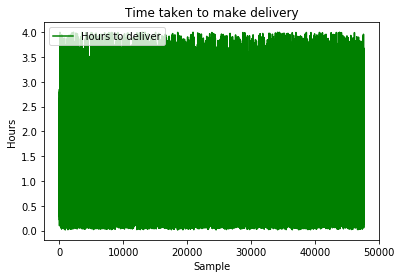

In [6]:
is_strange =  info_taken['Hours2deliver']>4
info_taken= info_taken[~is_strange]
plt.plot(info_taken['Hours2deliver'].values, color= 'green', label= 'Hours to deliver') # p
plt.ylabel('Hours')
plt.xlabel('Sample')
plt.title('Time taken to make delivery')
plt.legend()
plt.show()

In [95]:
timstamp_into_int = info_taken['Created Time'].values.astype(int)
location_code = info_taken[['LocationCode']].values
X = np.insert(location_code, 1,timstamp_into_int , axis=1)
Y = np.reshape(info_taken['Hours2deliver'].values, -1)
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=0.3, random_state=42)

In [96]:
from sklearn.metrics import make_scorer
tree_regression_Model = tree.DecisionTreeRegressor(random_state=0)
scoring = make_scorer(r2_score)
parameters={'max_depth': np.arange(15, 30), 'min_samples_split':np.arange(30, 42)}
#cross_validation = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(tree_regression_Model, parameters, cv=10, n_jobs=4, refit=True, scoring=scoring,verbose=1)

In [97]:
#grid_search = tree.DecisionTreeRegressor(criterion='mae', random_state=0, max_depth=19, min_samples_split=45)
grid_search.fit(X_trn,Y_trn)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 744 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 1744 tasks      | elapsed:   37.0s
[Parallel(n_jobs=4)]: Done 1800 out of 1800 | elapsed:   38.3s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'min_samples_split': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]), 'max_depth': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=1)

In [98]:
print(grid_search.best_params_)
print(grid_search.best_estimator_.feature_importances_)

{'min_samples_split': 31, 'max_depth': 29}
[0.20494528 0.79505472]


In [99]:
#predict_model = trained_model.predict(X_tst)
predict_model = grid_search.best_estimator_.predict(X_tst)

In [100]:
print("Mean squared error: "  )
mse= mean_squared_error(Y_tst, predict_model,)
print(mse)

print('r2')
r2 = r2_score(Y_tst, predict_model, sample_weight=None, multioutput='uniform_average')
print(r2)
adj_r2 = 1-(1-r2) * (X_tst.shape[0] -1)/(X_tst.shape[0]-X_tst.shape[1] -1)
adj_r2

Mean squared error: 
0.4966756966248723
r2
0.28310802943363444


0.2830075821910162

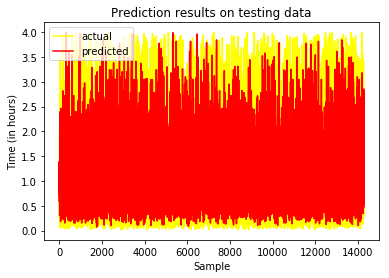

In [102]:
plt.plot(Y_tst, color= 'yellow', label= 'actual') # p
plt.plot(predict_model, color= 'red', label= 'predicted') # p
plt.xlabel('Sample')
plt.ylabel('Time (in hours)')
plt.title('Prediction results on testing data')
plt.legend()
plt.show()